## Exploring chess.com API - data analysis

In [1]:
import pandas as pd
import chessdotcom as chesscom
import pgn_parser
from pgn_parser import pgn, parser
import re
import datetime

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Function to show values on a seaborn / matplotlib barplot.

Credits goes to users "Sharon Soussan and "Secant Zhang" on Stack Exchange who posted it.

https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values

In [2]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

To utilize the API, the user has to determine which username he wants to extract the data from, as well as month and year. The cell below sets up these infos.

In [3]:
username = "itteram"
month = "12"
year = "2020"

In [4]:
player = chesscom.get_player_games_by_month(username = username, year = year, month = month)

In [5]:
print("User {} has played {} games in {}/{}".format(username, len(player.json["games"]), month, year))

User itteram has played 398 games in 12/2020


We need to parse the data to find the infos that we want:
- Opening
- Game type: (blitz, rapids, etc)
- Color played by user, etc.


### For loop to extract infos from each game such as moves, color played, usernames, opening, etc.

In [6]:
games = {}
for i in range(len(player.json["games"])):
    
    #Parsing game info from PGN
    game = parser.parse(player.json["games"][i]["pgn"], actions=pgn.Actions())
    gamemoves = game.movetext
    gamemoves = str(gamemoves)
    gamemoves = re.sub(r'\d\d\d\.\.\.', '', gamemoves)
    gamemoves = re.sub(r'\d\d\.\.\.', '', gamemoves)
    gamemoves = re.sub(r'\d\.\.\.', '', gamemoves)
    gamemoves = re.sub(r'\{(.*?)\}', '', gamemoves)
    gamemoves = gamemoves.strip()
    game1 = parser.parse(gamemoves, actions=pgn.Actions())
    
    moves = []
    moves_black = []
    moves_white = []
    
    #First moves for black and white separated
    
    for j in range(1):
        try:
            moves_black.append(game1.move(j+1).black.san)
            moves_white.append(game1.move(j+1).white.san)
        except Exception:
            break
    moves.append(moves_white)
    moves.append(moves_black)
    games[i+1] = moves
    
    #First 2 moves for black and white separated
    
    moves = []
    moves_black = []
    moves_white = []
    
    for j in range(2):
        try:
            moves_black.append(game1.move(j+1).black.san)
            moves_white.append(game1.move(j+1).white.san)
        except Exception:
            break
    games[i+1].append(moves_white)
    games[i+1].append(moves_black)
    
    #First 3 moves for black and white separated
    
    moves = []
    moves_black = []
    moves_white = []
    
    for j in range(3):
        try:
            moves_black.append(game1.move(j+1).black.san)
            moves_white.append(game1.move(j+1).white.san)
        except Exception:
            break
    games[i+1].append(moves_white)
    games[i+1].append(moves_black)
    
    #First 4 moves for black and white separated
    
    moves = []
    moves_black = []
    moves_white = []
    
    for j in range(4):
        try:
            moves_black.append(game1.move(j+1).black.san)
            moves_white.append(game1.move(j+1).white.san)
        except Exception:
            break
    games[i+1].append(moves_white)
    games[i+1].append(moves_black)
    
    #First 4 moves altogether
    
    moves = []
    moves_black = []
    moves_white = []
    
    for j in range(4):
        try:
            moves.append(game1.move(j+1))
        except Exception:
            break
    moves.append(moves)
    games[i+1].append(moves)
    
    #Game date
    games[i+1].append(game.tag_pairs["Date"])
    
    #Time class
    games[i+1].append(player.json["games"][i]["time_class"])
    
    #Time control
    games[i+1].append(player.json["games"][i]["time_control"])
    
    #Extracting and appending opening
    try:
        opening = game.tag_pairs["ECOUrl"].split('/')[-1]
        opening = re.sub(r'-', ' ', opening)
        games[i+1].append(opening)
    except KeyError:
        if type(game.tag_pairs["Tournament"]) is str:
            opening = "Tournament game"
            games[i+1].append(opening)
        else:
            opening = "Opening not found"
            games[i+1].append(opening)
    
    
    #The try-except clause is because apparently for tournament games the tag_pairs method does not have
    #the "ECOUrl" object and this whole parsing cell crashed. This needs to be investigated further    
    
    #Extracting and appending white player and rating
    white = game.tag_pairs["White"]
    rating = int(game.tag_pairs["WhiteElo"])
    games[i+1].append(white)
    games[i+1].append(rating)
    
    #Extracting and appending black player
    black = game.tag_pairs["Black"]
    rating = int(game.tag_pairs["BlackElo"])
    games[i+1].append(black)
    games[i+1].append(rating)
    
    #Extracting and appending result
    result = game.tag_pairs["Result"]
    games[i+1].append(result)

Setting up the column names for our dataframe

In [8]:
df_columns = ["White 1st move", "Black 1st move", "White first 2 moves" ,"Black first 2 moves", "White first 3 moves",
              "Black first 3 moves", "White first 4 moves", "Black first 4 moves", "First 4 moves", "Date", 
              "Game type", "Time control", "Opening", "White player", "White player rating",
              "Black player", "Black player rating", "Result"]

In [9]:
# Example of info extracted from a particular game
games[1]

[['e4'],
 ['e5'],
 ['e4', 'Nf3'],
 ['e5', 'Bc5'],
 ['e4', 'Nf3', 'Bc4'],
 ['e5', 'Bc5', 'f6'],
 ['e4', 'Nf3', 'Bc4', 'c3'],
 ['e5', 'Bc5', 'f6', 'Nc6'],
 [1. e4 e5, 2. Nf3 Bc5, 3. Bc4 f6, 4. c3 Nc6, [...]],
 '2020.12.02',
 'rapid',
 '600',
 'Kings Pawn Opening Kings Knight Busch Gass Gambit',
 'itteram',
 1096,
 'NewEnglandCM',
 1085,
 '0-1']

In [10]:
games1=[]

for i in range(len(games)):
    games1.append(games[i+1])

In [11]:
df = pd.DataFrame(games1, columns = df_columns)

Basic feature engineering and EDA

In [12]:
df['Date'] =  pd.to_datetime(df['Date'], format='%Y.%m.%d')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   White 1st move       398 non-null    object        
 1   Black 1st move       398 non-null    object        
 2   White first 2 moves  398 non-null    object        
 3   Black first 2 moves  398 non-null    object        
 4   White first 3 moves  398 non-null    object        
 5   Black first 3 moves  398 non-null    object        
 6   White first 4 moves  398 non-null    object        
 7   Black first 4 moves  398 non-null    object        
 8   First 4 moves        398 non-null    object        
 9   Date                 398 non-null    datetime64[ns]
 10  Game type            398 non-null    object        
 11  Time control         398 non-null    object        
 12  Opening              398 non-null    object        
 13  White player         398 non-null  

In [14]:
#Creating a variable that says the color that the user played in each game. This will be helpful for stratified EDA

import numpy as np
df['Rating'] = np.where(df['White player']=='itteram', df['White player rating'], df['Black player rating'])
df['Color'] = np.where(df['White player']=='itteram', "White", "Black")

In [15]:
pd.set_option('max_columns', None)
df.sort_values(by = "Day", ascending = False).head()

,White 1st move,Black 1st move,White first 2 moves,Black first 2 moves,White first 3 moves,Black first 3 moves,White first 4 moves,Black first 4 moves,First 4 moves,Date,Game type,Time control,Opening,White player,White player rating,Black player,Black player rating,Result,Year,Month,Day,Rating,Color
383,[e4],[c5],"[e4, d4]","[c5, cxd4]","[e4, d4, c3]","[c5, cxd4, dxc3]","[e4, d4, c3, Bc4]","[c5, cxd4, dxc3, cxb2]","[1. e4 c5, 2. d4 cxd4, 3. c3 dxc3, 4. Bc4 cxb2...",2020-12-31,blitz,300,Sicilian Defense Smith Morra Gambit Accepted,oli83YNWA,814,itteram,920,0-1,2020,12,31,920,Black
378,[e4],[c5],"[e4, d3]","[c5, Nc6]","[e4, d3, c3]","[c5, Nc6, d6]","[e4, d3, c3, f3]","[c5, Nc6, d6, Nf6]","[1. e4 c5, 2. d3 Nc6, 3. c3 d6, 4. f3 Nf6, [1....",2020-12-31,blitz,300,Sicilian Defense 2.d3 Nc6 3.c3 d6,afplacerda,798,itteram,913,1/2-1/2,2020,12,31,913,Black
384,[d4],[d5],"[d4, c4]","[d5, c6]","[d4, c4, Nc3]","[d5, c6, Nf6]","[d4, c4, Nc3, g3]","[d5, c6, Nf6, Bg4]","[1. d4 d5, 2. c4 c6, 3. Nc3 Nf6, 4. g3 Bg4, [1...",2020-12-31,blitz,300,Slav Defense 3.Nc3,itteram,926,Kaneda94,830,1-0,2020,12,31,926,White
370,[e4],[c5],"[e4, d3]","[c5, d6]","[e4, d3, h3]","[c5, d6, Nc6]","[e4, d3, h3, c3]","[c5, d6, Nc6, Nf6]","[1. e4 c5, 2. d3 d6, 3. h3 Nc6, 4. c3 Nf6, [1....",2020-12-31,blitz,300,Sicilian Defense 2.d3,abuyamis789,887,itteram,913,0-1,2020,12,31,913,Black
371,[e4],[c5],"[e4, f4]","[c5, d5]","[e4, f4, e5]","[c5, d5, Nc6]","[e4, f4, e5, c3]","[c5, d5, Nc6, e6]","[1. e4 c5, 2. f4 d5, 3. e5 Nc6, 4. c3 e6, [1. ...",2020-12-31,blitz,300,Sicilian Defense McDonnell Attack 2...d5 3.e5,sjhipple,877,itteram,920,0-1,2020,12,31,920,Black


In [16]:
df.columns

Index(['White 1st move', 'Black 1st move', 'White first 2 moves',
       'Black first 2 moves', 'White first 3 moves', 'Black first 3 moves',
       'White first 4 moves', 'Black first 4 moves', 'First 4 moves', 'Date',
       'Game type', 'Time control', 'Opening', 'White player',
       'White player rating', 'Black player', 'Black player rating', 'Result',
       'Year', 'Month', 'Day', 'Rating', 'Color'],
      dtype='object')

In [17]:
df[['White 1st move', 'Black 1st move', 'White first 2 moves',
       'Black first 2 moves', 'White first 3 moves', 'Black first 3 moves',
       'White first 4 moves', 'Black first 4 moves', 'First 4 moves']] = df[['White 1st move', 'Black 1st move', 'White first 2 moves',
       'Black first 2 moves', 'White first 3 moves', 'Black first 3 moves',
       'White first 4 moves', 'Black first 4 moves', 'First 4 moves']].astype(str)

In [18]:
df["Game type"].unique()

array(['rapid', 'blitz', 'bullet', 'daily'], dtype=object)

In [19]:
df["Game type"] = df["Game type"].apply(lambda x: x.capitalize())

In [20]:
game_type = "Rapid"

#options are "Rapid", "Blitz" or "Bullet"

In [21]:
g = df[df["Game type"] == game_type]
g = g.groupby(['Day'])[g.columns[g.columns == 'Rating']].max().reset_index()
g.head()

,Day,Rating
0,2,1115
1,3,1116
2,4,1125
3,5,1130
4,6,1122


### Rating evolution: Daily average

#### Rapid

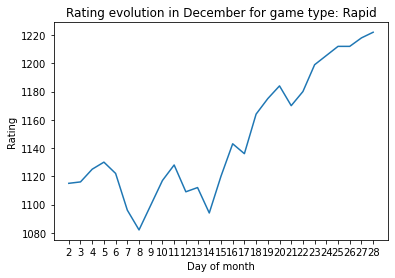

In [22]:
plt.plot(g['Day'], g['Rating'])
plt.title("Rating evolution in December for game type: " + game_type)
plt.xlabel("Day of month")
plt.xticks(np.arange(min(g['Day']), max(g['Day'])+1, 1.0))
plt.ylabel("Rating")
plt.show()

#### Blitz

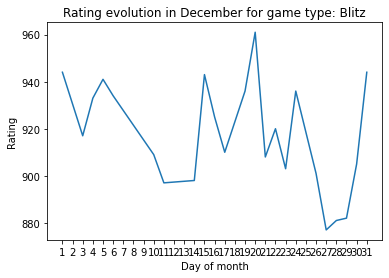

In [23]:
game_type = "Blitz"
g = df[df["Game type"] == game_type]
g = g.groupby(['Day'])[g.columns[g.columns == 'Rating']].max().reset_index()
g.head()

plt.plot(g['Day'], g['Rating'])
plt.title("Rating evolution in December for game type: " + game_type)
plt.xlabel("Day of month")
plt.xticks(np.arange(min(g['Day']), max(g['Day'])+1, 1.0))
plt.ylabel("Rating")
plt.show()

### Analysing defeats

### Game type: Rapid

In [24]:
game_type = "Rapid"

In [25]:
df_rapid = df[df["Game type"] == game_type]

#### Checking wins and losses when playing black and white

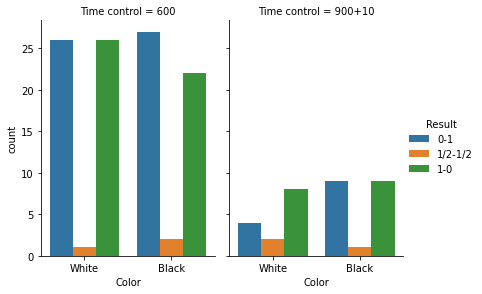

In [26]:
#clrs = ['blue' if x == "White" else 'black' for x in df_rapid['Color'] ]

#ax = sns.countplot(x="Color", hue = "Time control" , data=df_rapid[df_rapid["Result"] == "0-1"]) only losses

#percentage = lambda i: len(i) / float(len(x)) * 100


ax = sns.catplot(x="Color", hue="Result", col="Time control", 
                data=df_rapid, kind="count",
                height=4, aspect=.7)

#ax.set(ylabel="Percent")

Calcular o percentual de vitórias / derrotas e mostrar em tabela e ordenar as barras (colocar as derrotas em vermelho)

In [27]:
df_rapid_L = df_rapid[(df_rapid["Time control"] == "600") & (df_rapid["Color"] == "Black") & (df_rapid["Result"] == "0-1")]

[]

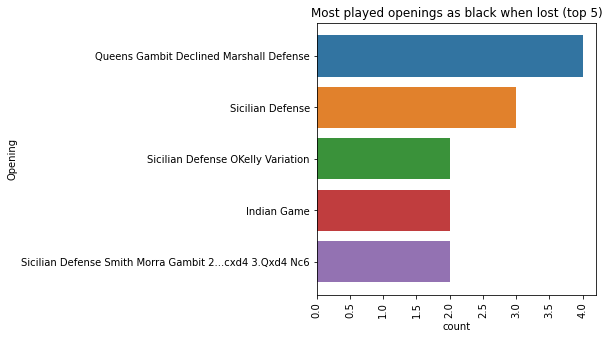

In [28]:
plt.figure(figsize=(5,5))
ax = sns.countplot(y="Opening", data = df_rapid_L,  order = df_rapid_L['Opening'].value_counts().iloc[:5].index)
plt.xticks(rotation=90)
plt.title('Most played openings as black when lost (top 5)', fontsize=12)
ax.plot()


The first opening is actually a delayed London System, which I knew by intuition I was having trouble against. Need to practice countering that (get that e5 going asap lol)

In [29]:
a = df_rapid.groupby("Opening")["Black player"].count().sort_values(ascending = False).nlargest(5).reset_index()

In [30]:
a = a.rename(columns={"Black player": "Games played"})

a['% losses'] = 0

a

,Opening,Games played,% losses
0,Indian Game,10,0
1,Sicilian Defense 2.Nf3 d6,7,0
2,Queens Gambit Declined Marshall Defense,6,0
3,Italian Game Two Knights Modern Bishops Opening,5,0
4,Italian Game Anti Fried Liver Defense,4,0


In [31]:
b = df_rapid_L.groupby("Opening")["Black player"].count().sort_values(ascending = False).nlargest(20)

In [32]:
openings = a.Opening.unique().tolist()
openings

['Indian Game',
 'Sicilian Defense 2.Nf3 d6',
 'Queens Gambit Declined Marshall Defense',
 'Italian Game Two Knights Modern Bishops Opening',
 'Italian Game Anti Fried Liver Defense']

In [33]:
a = a.set_index("Opening")

In [34]:
for i in openings:
    try:
        a.loc[i]['% losses'] = round(b.loc[i] / a.loc[i]['Games played']*100, 3)
    except KeyError:
        break

In [35]:
a

,Games played,% losses
Opening,,
Indian Game,10,20
Sicilian Defense 2.Nf3 d6,7,28
Queens Gambit Declined Marshall Defense,6,66
Italian Game Two Knights Modern Bishops Opening,5,0
Italian Game Anti Fried Liver Defense,4,0


In [36]:
a.loc['Indian Game']['% losses'] = 5

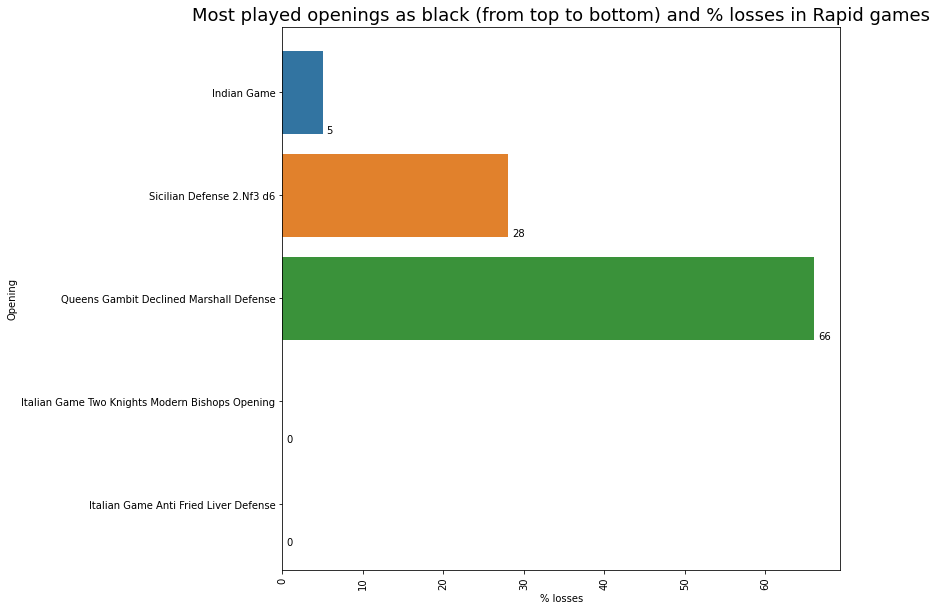

In [37]:
plt.figure(figsize=(10,10))
ax = sns.barplot(x="% losses", y = 'Opening', data = a.reset_index(), order = a['Games played'].index)
plt.xticks(rotation=90)
ax.plot()

plt.title('Most played openings as black (from top to bottom) and % losses in Rapid games' , fontsize=18)

show_values_on_bars(ax, "h", 0.5)


## Game type: Blitz (5' or 3')

In [38]:
game_type = "Blitz"
df_blitz = df[df["Game type"] == game_type]

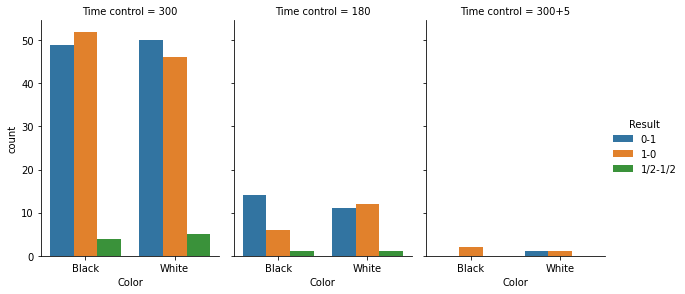

In [39]:
ax = sns.catplot(x="Color", hue="Result", col="Time control", 
                data=df_blitz, kind="count",
                height=4, aspect=.7)

Surprisingly I have been losing more as white than black

[]

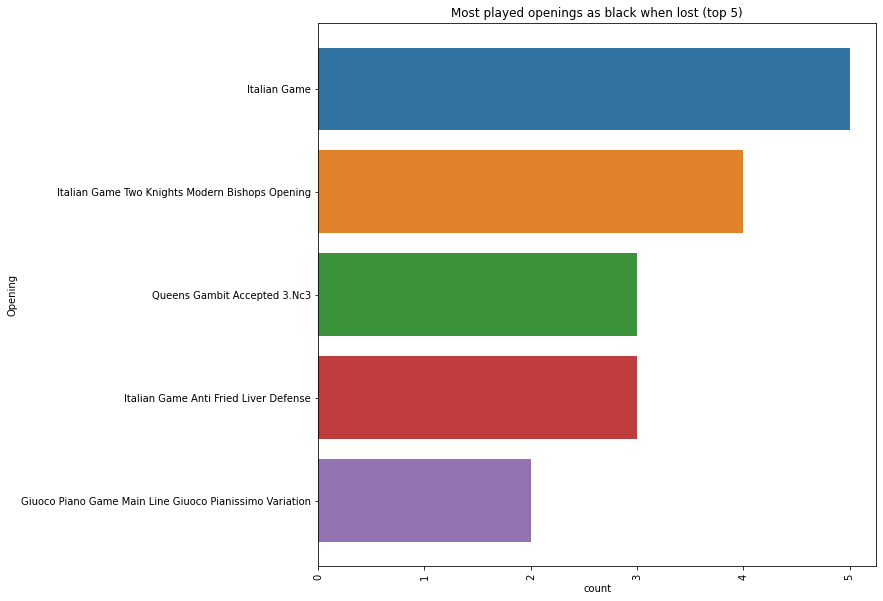

In [40]:
df_blitz_300_L = df_blitz[(df_blitz["Time control"] == "300") & (df_blitz["Color"] == "White") & (df_blitz["Result"] == "0-1")]

plt.figure(figsize=(10,10))
ax = sns.countplot(y=df_blitz_300_L["Opening"], data = df_blitz_300_L,  order = df_blitz_300_L['Opening'].value_counts().iloc[:5].index)
plt.xticks(rotation=90)
plt.title('Most played openings as black when lost (top 5)', fontsize=12)
ax.plot()


Apparently gotta work on the Italian opening. Let's check the percentage of losses, that way we take into account how many times the opening was played

In [41]:
df_blitz_300_W = df_blitz[(df_blitz["Time control"] == "300") & (df_blitz["Color"] == "White")]


In [42]:
df_blitz_300_W.groupby("Opening")["White player"].count().sort_values(ascending = False).nlargest(5)

Opening
Italian Game Two Knights Modern Bishops Opening    7
Italian Game                                       6
Queens Gambit Accepted 3.Nc3                       6
Italian Game Anti Fried Liver Defense              4
Giuoco Piano Game 4.O O Nf6                        4
Name: White player, dtype: int64

In [43]:
print("The most used opening used by {} as White was {} and lost {} games, {} %".format(username, 
                                                                                        df_blitz_300_W.groupby("Opening")["White player"].count().sort_values(ascending = False).nlargest(5).reset_index()["Opening"][0], 
                                                                                        df_blitz_300_L.groupby("Opening")["White player"].count().sort_values(ascending = False).nlargest(5)[0],
                                                                                        ((df_blitz_300_L.groupby("Opening")["White player"].count().sort_values(ascending = False).nlargest(5)[0])/(df_blitz_300_W.groupby("Opening")["White player"].count().sort_values(ascending = False).nlargest(5)[0]))*100))



The most used opening used by itteram as White was Italian Game Two Knights Modern Bishops Opening and lost 5 games, 71.42857142857143 %


In [44]:
print("The second most used opening used by {} as White was {} and lost {} games, {} %".format(username, 
                                                                                        df_blitz_300_W.groupby("Opening")["White player"].count().sort_values(ascending = False).nlargest(5).reset_index()["Opening"][1], 
                                                                                        df_blitz_300_L.groupby("Opening")["White player"].count().sort_values(ascending = False).nlargest(5)[1],
                                                                                        ((df_blitz_300_L.groupby("Opening")["White player"].count().sort_values(ascending = False).nlargest(5)[1])/(df_blitz_300_W.groupby("Opening")["White player"].count().sort_values(ascending = False).nlargest(5)[1]))*100))



The second most used opening used by itteram as White was Italian Game and lost 4 games, 66.66666666666666 %


In [45]:
print("When {} as White played the {}, lost {} games out of {}, {} %".format(username, 
                                                                    df_blitz_300_W.groupby("Opening")["White player"].count().sort_values(ascending = False).nlargest(5).reset_index()["Opening"][4], 
                                                                    df_blitz_300_L.groupby("Opening")["White player"].count().sort_values(ascending = False).nlargest(5)[4],
                                                                    df_blitz_300_W.groupby("Opening")["White player"].count().sort_values(ascending = False).nlargest(5)[4],         
                                                                    ((df_blitz_300_L.groupby("Opening")["White player"].count().sort_values(ascending = False).nlargest(5)[4])/(df_blitz_300_W.groupby("Opening")["White player"].count().sort_values(ascending = False).nlargest(5)[4]))*100))



When itteram as White played the Giuoco Piano Game 4.O O Nf6, lost 2 games out of 4, 50.0 %


In [46]:
a = df_blitz_300_W.groupby("Opening")["White player"].count().sort_values(ascending = False).nlargest(5).reset_index()

a = a.rename(columns={"White player": "Games played"})

a['% losses'] = 0

a

,Opening,Games played,% losses
0,Italian Game Two Knights Modern Bishops Opening,7,0
1,Italian Game,6,0
2,Queens Gambit Accepted 3.Nc3,6,0
3,Italian Game Anti Fried Liver Defense,4,0
4,Giuoco Piano Game 4.O O Nf6,4,0


In [47]:
openings = a["Opening"].unique().tolist()
openings

['Italian Game Two Knights Modern Bishops Opening',
 'Italian Game',
 'Queens Gambit Accepted 3.Nc3',
 'Italian Game Anti Fried Liver Defense',
 'Giuoco Piano Game 4.O O Nf6']

In [48]:
a = a.set_index("Opening")

In [49]:
a.loc['Italian Game']['% losses']

0

In [50]:
b = df_blitz_300_L.groupby("Opening")["White player"].count().sort_values(ascending = False).nlargest(10)#.reset_index()

b

Opening
Italian Game                                               5
Italian Game Two Knights Modern Bishops Opening            4
Queens Gambit Accepted 3.Nc3                               3
Italian Game Anti Fried Liver Defense                      3
Giuoco Piano Game Main Line Giuoco Pianissimo Variation    2
Giuoco Piano Game 4.O O Nf6                                2
Giuoco Piano Game Giuoco Pianissimo Variation 4...Nf6      2
Queens Pawn Opening Horwitz Defense 2.c4                   2
Reti Opening Tennison Gambit                               2
Italian Game Two Knights Open 4...exd4                     1
Name: White player, dtype: int64

In [51]:
b.loc['Italian Game']

5

In [52]:
for i in openings:
    try:
        a.loc[i]['% losses'] = round(b.loc[i] / a.loc[i]['Games played']*100, 3)
    except KeyError:
        break

In [53]:
a

,Games played,% losses
Opening,,
Italian Game Two Knights Modern Bishops Opening,7,57
Italian Game,6,83
Queens Gambit Accepted 3.Nc3,6,50
Italian Game Anti Fried Liver Defense,4,75
Giuoco Piano Game 4.O O Nf6,4,50


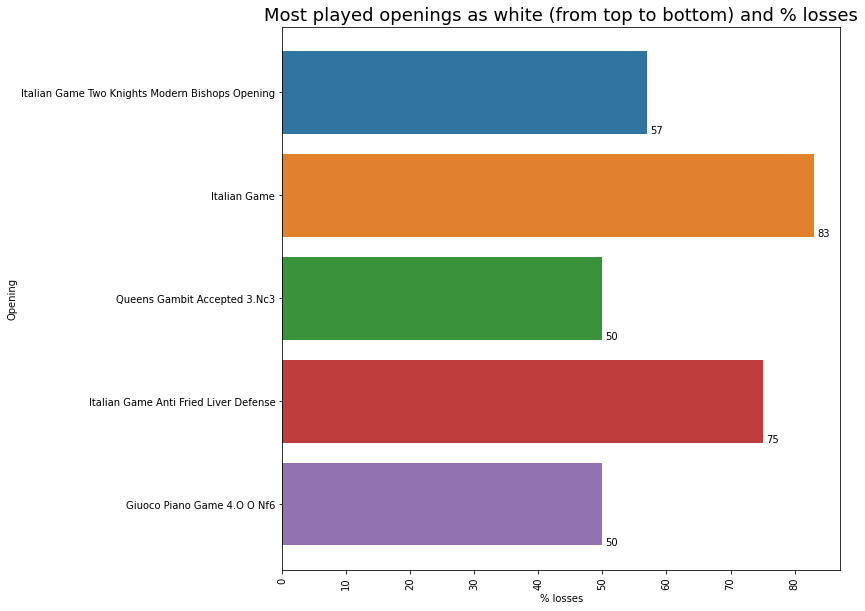

In [54]:
plt.figure(figsize=(10,10))
ax = sns.barplot(x="% losses", y = 'Opening', data = a.reset_index(), order = a['Games played'].index)
plt.xticks(rotation=90)
ax.plot()

plt.title('Most played openings as white (from top to bottom) and % losses', fontsize=18)

show_values_on_bars(ax, "h", 0.5)



### Generating table of games on specific opening for review

In [55]:
opening = 'Italian Game'

In [56]:
games = df_blitz_300_W[(df_blitz_300_W["Opening"] == opening) & (df_blitz["Result"] == "0-1")]

games


/Users/lucasmaretti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,White 1st move,Black 1st move,White first 2 moves,Black first 2 moves,White first 3 moves,Black first 3 moves,White first 4 moves,Black first 4 moves,First 4 moves,Date,Game type,Time control,Opening,White player,White player rating,Black player,Black player rating,Result,Year,Month,Day,Rating,Color
67,['e4'],['e5'],"['e4', 'Nf3']","['e5', 'Nc6']","['e4', 'Nf3', 'Bc4']","['e5', 'Nc6', 'f6']","['e4', 'Nf3', 'Bc4', 'O-O']","['e5', 'Nc6', 'f6', 'Nge7']","[1. e4 e5, 2. Nf3 Nc6, 3. Bc4 f6, 4. O-O Nge7,...",2020-12-10,Blitz,300,Italian Game,itteram,892,otto88,862,0-1,2020,12,10,892,White
212,['e4'],['e5'],"['e4', 'Nf3']","['e5', 'Nc6']","['e4', 'Nf3', 'Bc4']","['e5', 'Nc6', 'd5']","['e4', 'Nf3', 'Bc4', 'exd5']","['e5', 'Nc6', 'd5', 'Nd4']","[1. e4 e5, 2. Nf3 Nc6, 3. Bc4 d5, 4. exd5 Nd4,...",2020-12-22,Blitz,300,Italian Game,itteram,901,HananZaguri,942,0-1,2020,12,22,901,White
237,['e4'],['e5'],"['e4', 'Nf3']","['e5', 'Nc6']","['e4', 'Nf3', 'Bc4']","['e5', 'Nc6', 'd6']","['e4', 'Nf3', 'Bc4', 'c3']","['e5', 'Nc6', 'd6', 'Bg4']","[1. e4 e5, 2. Nf3 Nc6, 3. Bc4 d6, 4. c3 Bg4, [...",2020-12-23,Blitz,300,Italian Game,itteram,893,hedgehog_bishop,846,0-1,2020,12,23,893,White
294,['e4'],['e5'],"['e4', 'Nf3']","['e5', 'Nc6']","['e4', 'Nf3', 'Bc4']","['e5', 'Nc6', 'f6']","['e4', 'Nf3', 'Bc4', 'c3']","['e5', 'Nc6', 'f6', 'a6']","[1. e4 e5, 2. Nf3 Nc6, 3. Bc4 f6, 4. c3 a6, [....",2020-12-26,Blitz,300,Italian Game,itteram,871,DarkFighter42,912,0-1,2020,12,26,871,White
318,['e4'],['e5'],"['e4', 'Nf3']","['e5', 'Nc6']","['e4', 'Nf3', 'Bc4']","['e5', 'Nc6', 'd6']","['e4', 'Nf3', 'Bc4', 'c3']","['e5', 'Nc6', 'd6', 'Nf6']","[1. e4 e5, 2. Nf3 Nc6, 3. Bc4 d6, 4. c3 Nf6, [...",2020-12-28,Blitz,300,Italian Game,itteram,864,funk61,901,0-1,2020,12,28,864,White


In [57]:
print(games.iloc[1]['First 4 moves'], flush = True)

[1. e4 e5, 2. Nf3 Nc6, 3. Bc4 d5, 4. exd5 Nd4, [...]]


On a side note, there's also a cool package called chess where you can plot a chess board on the notebook by passing a pgn string

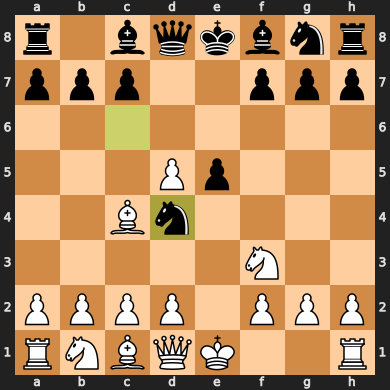

In [58]:
import chess.pgn
import io

pgn = io.StringIO('1. e4 e5 2. Nf3 Nc6 3. Bc4 d5 4. exd5 Nd4')
game = chess.pgn.read_game(pgn)


# Iterate through all moves and play them on a board.
board = game.board()
for move in game.mainline_moves():
    board.push(move)

board